In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import glob
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import lines
from astropy.io import fits
from astropy import stats
from astropy.table import Table

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils

from myutils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [3]:
%%html
<style>
    /* Jupyter */
    .rendered_html table,
    /* Jupyter Lab*/
    div[data-mime-type="text-markdown"] table {
        margin-left: 0
    }
</style>

In [4]:
# loop over bays, compare READ_NOISE in two BOT runs 
def compare_tworuns(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True,legend_loc='lower right',scale='linear'):

    rtms = get_rtms()
    crtms = get_crtms()
    rtmids = get_rtmids()
    allrtms = rtms + crtms

    f,ax = plt.subplots(5,5,figsize=(22,22),constrained_layout=True)
    axf = ax

    for i,abay in enumerate(allrtms):

        thertm = rtmids[abay]
        ix = 4-int(abay[1:2])
        iy = int(abay[2:3])
        
        # get the desired quantity, filtered by raft
        df1f = df1[df1.BAY==abay]
        df2f = df2[df2.BAY==abay]
        
        for aslot in get_slots_per_bay(abay):
           
            # filter by slot
            df1fs = df1f[df1f.SLOT==aslot]
            df2fs = df2f[df2f.SLOT==aslot]
                    
            quant1 = df1fs[quantity]
            quant2 = df2fs[quantity]
        
            # make sure we have entries
            if len(quant1)>0 and len(quant1)==len(quant2):
                axf[ix,iy].scatter(quant1,quant2,label=aslot)
                

        axf[ix,iy].text(0.07,0.9,'%s %s' % (abay,thertm),transform=axf[ix,iy].transAxes)
        axf[ix,iy].set_xlabel('%s Run %s' % (quantity,run1))
        axf[ix,iy].set_ylabel('%s Run %s' % (quantity,run2))
    
        axf[ix,iy].set_xlim(minxy,maxxy)
        axf[ix,iy].set_ylim(minxy,maxxy)
        
        ax[ix,iy].set_xscale(scale)
        ax[ix,iy].set_yscale(scale)

        if (ix==0 and iy==0) or (ix==0 and iy==1):
            axf[ix,iy].legend(loc=legend_loc)
        
        if draw_line:
            line = lines.Line2D([minxy,maxxy], [minxy,maxxy], lw=2., color='r', alpha=0.4)
            axf[ix,iy].add_line(line)
    
    

In [5]:
# loop over bays, compare READ_NOISE in two BOT runs 
def compare_tworuns_1d(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True):

    # merge df's
    df_merged = pd.merge(df1, df2, how='inner', on=['BAY','SLOT','AMP'],suffixes=('_1', '_2'))
    
    f,ax = plt.subplots(1,1,figsize=(7,7),constrained_layout=True)
    axf = ax

    axf.hist(df_merged[quantity+'_1']/df_merged[quantity+'_2'],bins=100,range=(minxy,maxxy))
    axf.set_xlabel('%s Run %s / Run %s' % (quantity,run1,run2))
    

In [6]:
# loop over bays, compare READ_NOISE in two BOT runs 
def difference_tworuns_1d(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True):

    # merge df's
    df_merged = pd.merge(df1, df2, how='inner', on=['BAY','SLOT','AMP'],suffixes=('_1', '_2'))
    
    f,ax = plt.subplots(1,1,figsize=(7,7),constrained_layout=True)
    axf = ax

    axf.hist(df_merged[quantity+'_1'] - df_merged[quantity+'_2'],bins=100,range=(minxy,maxxy))
    axf.set_xlabel('%s Run %s -  Run %s' % (quantity,run1,run2))

# Compare 'default' BOT runs vs. others

In [7]:
df_12845 = getDBinfoBOT(run='12845')
print(df_12845.columns)
print(len(df_12845.READ_NOISE))

Index(['MAX_OBSERVED_SIGNAL', 'MAX_FRAC_DEV', 'LINEARITY_TURNOFF', 'ROW_MEAN_VAR_SLOPE', 'CTI_LOW_PARALLEL', 'CTI_LOW_SERIAL_ERROR', 'CTI_LOW_SERIAL', 'CTI_HIGH_SERIAL_ERROR', 'CTI_HIGH_PARALLEL',
       'CTI_HIGH_SERIAL', 'CTI_LOW_PARALLEL_ERROR', 'CTI_HIGH_PARALLEL_ERROR', 'PTC_A00', 'PTC_NOISE', 'PTC_GAIN', 'PTC_A00_ERROR', 'PTC_TURNOFF', 'PTC_NOISE_ERROR', 'PTC_GAIN_ERROR',
       'DARK_CURRENT_MEDIAN', 'DARK_CURRENT_95CL', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS', 'TEARING_DETECTIONS', 'DIVISADERO_MAX_DEV', 'BF_SLOPEY_ERR', 'BF_YCORR_ERR',
       'BF_SLOPEX_ERR', 'BF_MEAN', 'BF_SLOPEX', 'BF_SLOPEY', 'BF_XCORR_ERR', 'BF_XCORR', 'BF_YCORR', 'TOTAL_NOISE', 'SYSTEM_NOISE', 'READ_NOISE', 'BAY', 'SLOT', 'AMP', 'BAYTYPE'],
      dtype='object')
3120


In [8]:
# print bad values (only science rafts, since corner rafts CCDs are off)
bad =( ((df_12845.READ_NOISE<4.0)|(df_12845.READ_NOISE>18.)|(df_12845.PTC_GAIN<.8)|(df_12845.PTC_GAIN>1.8)|(df_12845.MAX_OBSERVED_SIGNAL<4.e4)) & (df_12845.BAYTYPE=='S') ) 
print(df_12845[bad][['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','MAX_OBSERVED_SIGNAL','PTC_TURNOFF']])

      BAY SLOT  AMP BAYTYPE  READ_NOISE   PTC_GAIN  MAX_OBSERVED_SIGNAL    PTC_TURNOFF
4     R01  S00    5       S    6.500425   7.511176        120245.281250   34347.128906
11    R01  S00   12       S    6.251701   3.130768        122391.164062   34785.597656
40    R01  S02    9       S   21.299370   1.331784        143360.421875   97538.203125
367   R03  S11   16       S    5.246526   0.000000           281.963654       0.000000
1824  R30  S00    1       S    4.506235  23.431849             0.000000      -0.254609
2669  R41  S21   14       S   95.981544   1.156934        142788.500000   87462.781250
2828  R43  S02   13       S   18.111326   1.332622        117933.031250  117922.625000
2884  R43  S20    5       S   68.774780   1.401072        139915.734375   84866.023438


In [9]:
df_12795 = getDBinfoBOT(run='12795')  # v23_FF02 run in Nov

# print bad values
bad =( ((df_12795.READ_NOISE<4.0)|(df_12795.READ_NOISE>18.)|(df_12795.PTC_GAIN<.8)|(df_12795.PTC_GAIN>1.8)|(df_12795.MAX_OBSERVED_SIGNAL<4.e4)) ) 
print(df_12795[bad][['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','MAX_OBSERVED_SIGNAL','PTC_TURNOFF']])


      BAY SLOT  AMP BAYTYPE  READ_NOISE   PTC_GAIN  MAX_OBSERVED_SIGNAL   PTC_TURNOFF
4     R01  S00    5       S    6.551472  10.316327        120109.281250  35854.929688
40    R01  S02    9       S   20.207943   1.333110        143119.515625  97399.109375
1872  R30  S00    1       S    4.554500  24.848106             0.000000     -0.220839
2374  R33  S11    7       S    5.260218   0.000000        153815.593750      0.000000
2717  R41  S21   14       S  108.827812   1.359410        139467.718750  62008.582031
2924  R43  S02   13       S   18.343779   1.340974        117512.593750  96238.351562
3089  R04  SG0    2       C   11.491902   0.000000            25.525043      0.000000
3168  R40  SG1    1       C  121.568947   1.798075        138039.203125  86199.570312
3229  R44  SG0   14       C   69.080063   0.818803        144689.453125  30870.878906


In [10]:
df_12610 = getDBinfoBOT(run='12610')  # v22

print(df_12610.columns)

# print bad values
bad = ((df_12610.READ_NOISE<4.0)|(df_12610.READ_NOISE>18.)|(df_12610.PTC_GAIN<.8)|(df_12610.PTC_GAIN>1.8)|(df_12610.MAX_OBSERVED_SIGNAL<4.e4))
print(df_12610[bad][['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','MAX_OBSERVED_SIGNAL','PTC_TURNOFF']])

Index(['MAX_OBSERVED_SIGNAL', 'MAX_FRAC_DEV', 'ROW_MEAN_VAR_SLOPE', 'CTI_LOW_PARALLEL', 'CTI_LOW_SERIAL_ERROR', 'CTI_LOW_SERIAL', 'CTI_HIGH_SERIAL_ERROR', 'CTI_HIGH_PARALLEL', 'CTI_HIGH_SERIAL',
       'CTI_LOW_PARALLEL_ERROR', 'CTI_HIGH_PARALLEL_ERROR', 'PTC_A00', 'PTC_NOISE', 'PTC_GAIN', 'PTC_A00_ERROR', 'PTC_TURNOFF', 'PTC_NOISE_ERROR', 'PTC_GAIN_ERROR', 'DARK_CURRENT_MEDIAN',
       'DARK_CURRENT_95CL', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS', 'TEARING_DETECTIONS', 'DIVISADERO_MAX_DEV', 'BF_SLOPEY_ERR', 'BF_YCORR_ERR', 'BF_SLOPEX_ERR', 'BF_MEAN',
       'BF_SLOPEX', 'BF_SLOPEY', 'BF_XCORR_ERR', 'BF_XCORR', 'BF_YCORR', 'TOTAL_NOISE', 'SYSTEM_NOISE', 'READ_NOISE', 'BAY', 'SLOT', 'AMP', 'BAYTYPE'],
      dtype='object')
      BAY SLOT  AMP BAYTYPE  READ_NOISE    PTC_GAIN  MAX_OBSERVED_SIGNAL   PTC_TURNOFF
4     R01  S00    5       S    6.560085    0.000000        140731.921875      0.000000
11    R01  S00   12       S    6.247133  283.256195        141778.3125

In [11]:
#df_12433 = getDBinfoBOT(run='12433')  # 9 Raft run
df_12433 = getBOTEOInfo(run="12433",rtm_count=9) # 9 raft run

print(df_12433.columns)

# print bad values
bad =( ((df_12433.READ_NOISE<4.0)|(df_12433.READ_NOISE>18.)|(df_12433.PTC_GAIN<.8)|(df_12433.PTC_GAIN>1.8)|(df_12433.FULL_WELL<4.e4)) ) 
print(df_12433[bad][['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','FULL_WELL']])

Index(['AMP', 'GAIN', 'GAIN_ERROR', 'READ_NOISE', 'FULL_WELL', 'MAX_FRAC_DEV', 'CTI_HIGH_SERIAL', 'CTI_HIGH_PARALLEL', 'CTI_LOW_SERIAL', 'CTI_LOW_PARALLEL', 'DARK_CURRENT_95', 'NUM_BRIGHT_PIXELS',
       'NUM_TRAPS', 'PTC_GAIN', 'PTC_GAIN_ERROR', 'PTC_A00', 'PTC_A00_ERROR', 'PTC_NOISE', 'PTC_NOISE_ERROR', 'SYSTEM_NOISE', 'TOTAL_NOISE', 'NUM_BRIGHT_COLUMNS', 'NUM_DARK_PIXELS',
       'NUM_DARK_COLUMNS', 'DARK_CURRENT_MEDIAN', 'CTI_HIGH_SERIAL_ERROR', 'CTI_HIGH_PARALLEL_ERROR', 'CTI_LOW_SERIAL_ERROR', 'CTI_LOW_PARALLEL_ERROR', 'DC95_SHOT_NOISE', 'BAYSLOT', 'BAY', 'SLOT',
       'BAYTYPE'],
      dtype='object')
      BAY SLOT  AMP BAYTYPE  READ_NOISE    PTC_GAIN  FULL_WELL
40    R01  S02    9       S   26.671593    1.383742        NaN
79    R01  S11   16       S   24.209301    1.105774        NaN
1104  R30  S00    1       S  195.632660   26.927935        0.0
1299  R04  SG0    4       C   93.037605    1.276964        NaN
1300  R04  SG0    5       C   19.048801    1.269564        NaN
1302 

### Bad Channel comparison up to  Jan 2021

#### Including all Channels on Dead/Noisy List in Jan 2020 (see https://confluence.slac.stanford.edu/display/LSSTCAM/BOT+-+Known+Sensor+Defects)

| Raft | Slot | Segment | (Amp) | Problem | Single Raft testing | Run 12433 9-Raft (Oct '19)  | Run 12610 (Oct '20) | Run 12795 (Nov '20) | Run 12845 (Jan '21) | Comments |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| R01 | S01 | 00 | (16) | Dead Channel | Dead | Dead | OK | OK | OK | |
| R03 | S11 | 00 | (16) | Dead Channel | OK | NA | OK | OK | Dead | |
| R10 | S00 | 00 | (16) | Dead Channel | Dead | NA | OK  | OK | OK | |
| R30 | S00 | 10 | (1) | Dead Channel | Dead| Dead | Dead | Dead | Dead | |
| R01 | S02 | 07 | (9)  | Noise > 18e | OK | 27e | 22e | 20e | 21e | |
| R01 | S11 | 00 | (16) | Noise > 18e | OK | 24e | OK | OK | 12e |   |
| R41 | S11 | 14 | (5)  | Noise > 18e | OK | NA  | 36e | OK | OK |   |
| R41 | S21 | 02 | (14)  | Noise > 18e | OK | NA | OK | 108e | 96e | |
| R43 | S02 | 03 | (13)  | Noise > 18e | 18e | NA | 18e | 18e | 18e | |
| R43 | S20 | 14 | (5)  | Noise > 18e | OK | NA | OK | OK | 69e | | 
| R01 | S00 | 14 | (5) | Bright Defect | OK | Present | Present | Present | Present | |
| R01 | S00 | 04 | (12) | Bright Defect | OK | Present | Present | Present | Present |  |






In [12]:
# Study each channel listed above in each Run

dead_list = [['R01','S01',16],['R03','S11',16],['R10','S00',16],['R30','S00',1]]
noisy_list = [['R01','S02',9],['R01','S11',16],['R41','S11',5],['R41','S21',5],['R43','S02',13],['R43','S20',5]]
bad_list = dead_list + noisy_list

df_list = [df_12433,df_12610,df_12795,df_12845]
old_var_list = ['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','FULL_WELL']
new_var_list = ['BAY','SLOT','AMP','BAYTYPE','READ_NOISE','PTC_GAIN','MAX_OBSERVED_SIGNAL','PTC_TURNOFF']
var_list = [old_var_list,new_var_list,new_var_list,new_var_list]

for i,adf in enumerate(df_list):
    selection = (adf.BAY=='R99')  # all Falses...
    for achan in bad_list:
        raft = achan[0]
        slot = achan[1]
        amp = achan[2]   
        selection = selection | ((adf.BAY==raft)&(adf.SLOT==slot)&(adf.AMP==amp))

    vars = var_list[i]
    print(adf[selection][vars])
    

      BAY SLOT  AMP BAYTYPE  READ_NOISE   PTC_GAIN  FULL_WELL
31    R01  S01   16       S    6.962482   1.428283        NaN
40    R01  S02    9       S   26.671593   1.383742        NaN
79    R01  S11   16       S   24.209301   1.105774        NaN
1104  R30  S00    1       S  195.632660  26.927935        0.0
      BAY SLOT  AMP BAYTYPE  READ_NOISE   PTC_GAIN  MAX_OBSERVED_SIGNAL   PTC_TURNOFF
31    R01  S01   16       S    6.443164   1.412916        116101.023438  81984.117188
40    R01  S02    9       S   22.005943   1.329014        155249.718750  98391.164062
79    R01  S11   16       S    7.464487   1.121191        164779.765625  81581.781250
367   R03  S11   16       S    6.403046   1.476075        126131.140625  58612.355469
447   R10  S00   16       S    5.975598   1.482488        124137.523438  78038.304688
1872  R30  S00    1       S    4.508631  29.353645             0.000000     -0.232619
2660  R41  S11    5       S   35.572536   1.468372        135195.359375  70272.468750
27

# Compare default run vs. optimizations

In [13]:
df_12849 = getDBinfoBOT(run='12849')  # v25 DeltaRG = 10.5
df_12851 = getDBinfoBOT(run='12851')  # v25 Serial Swing = 9.5
df_12853 = getDBinfoBOT(run='12853')  # v25 ITL Serial Hi 5.5
df_12854 = getDBinfoBOT(run='12854')  # v25 ITL Serial Hi 5.8
df_12855 = getDBinfoBOT(run='12855')  # v25 ITL OG increased by 0.5




No handles with labels found to put in legend.


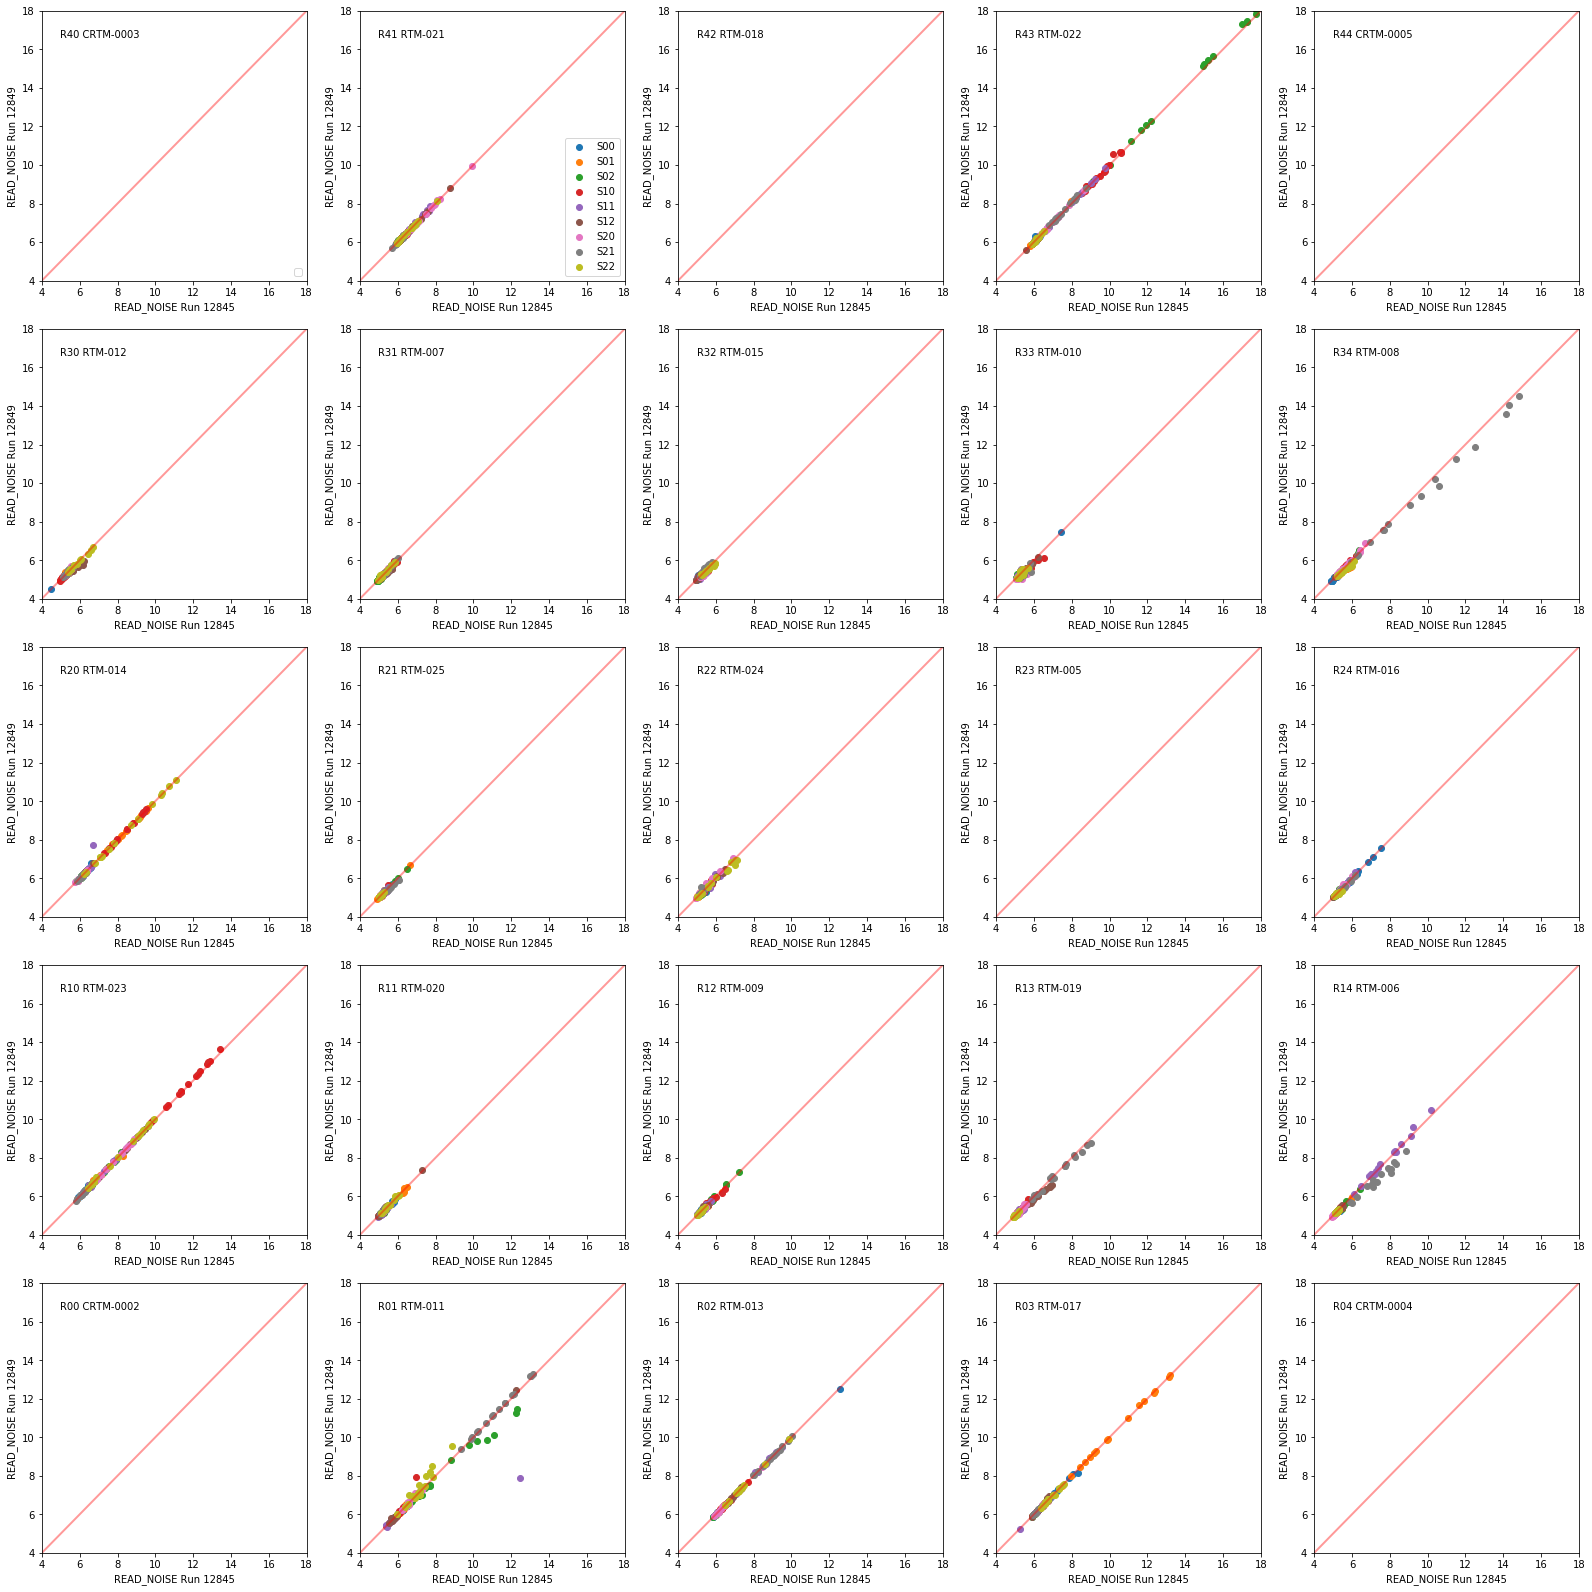

In [14]:
compare_tworuns(df_12845,df_12849,'12845','12849',minxy=4.,maxxy=18.)

No handles with labels found to put in legend.


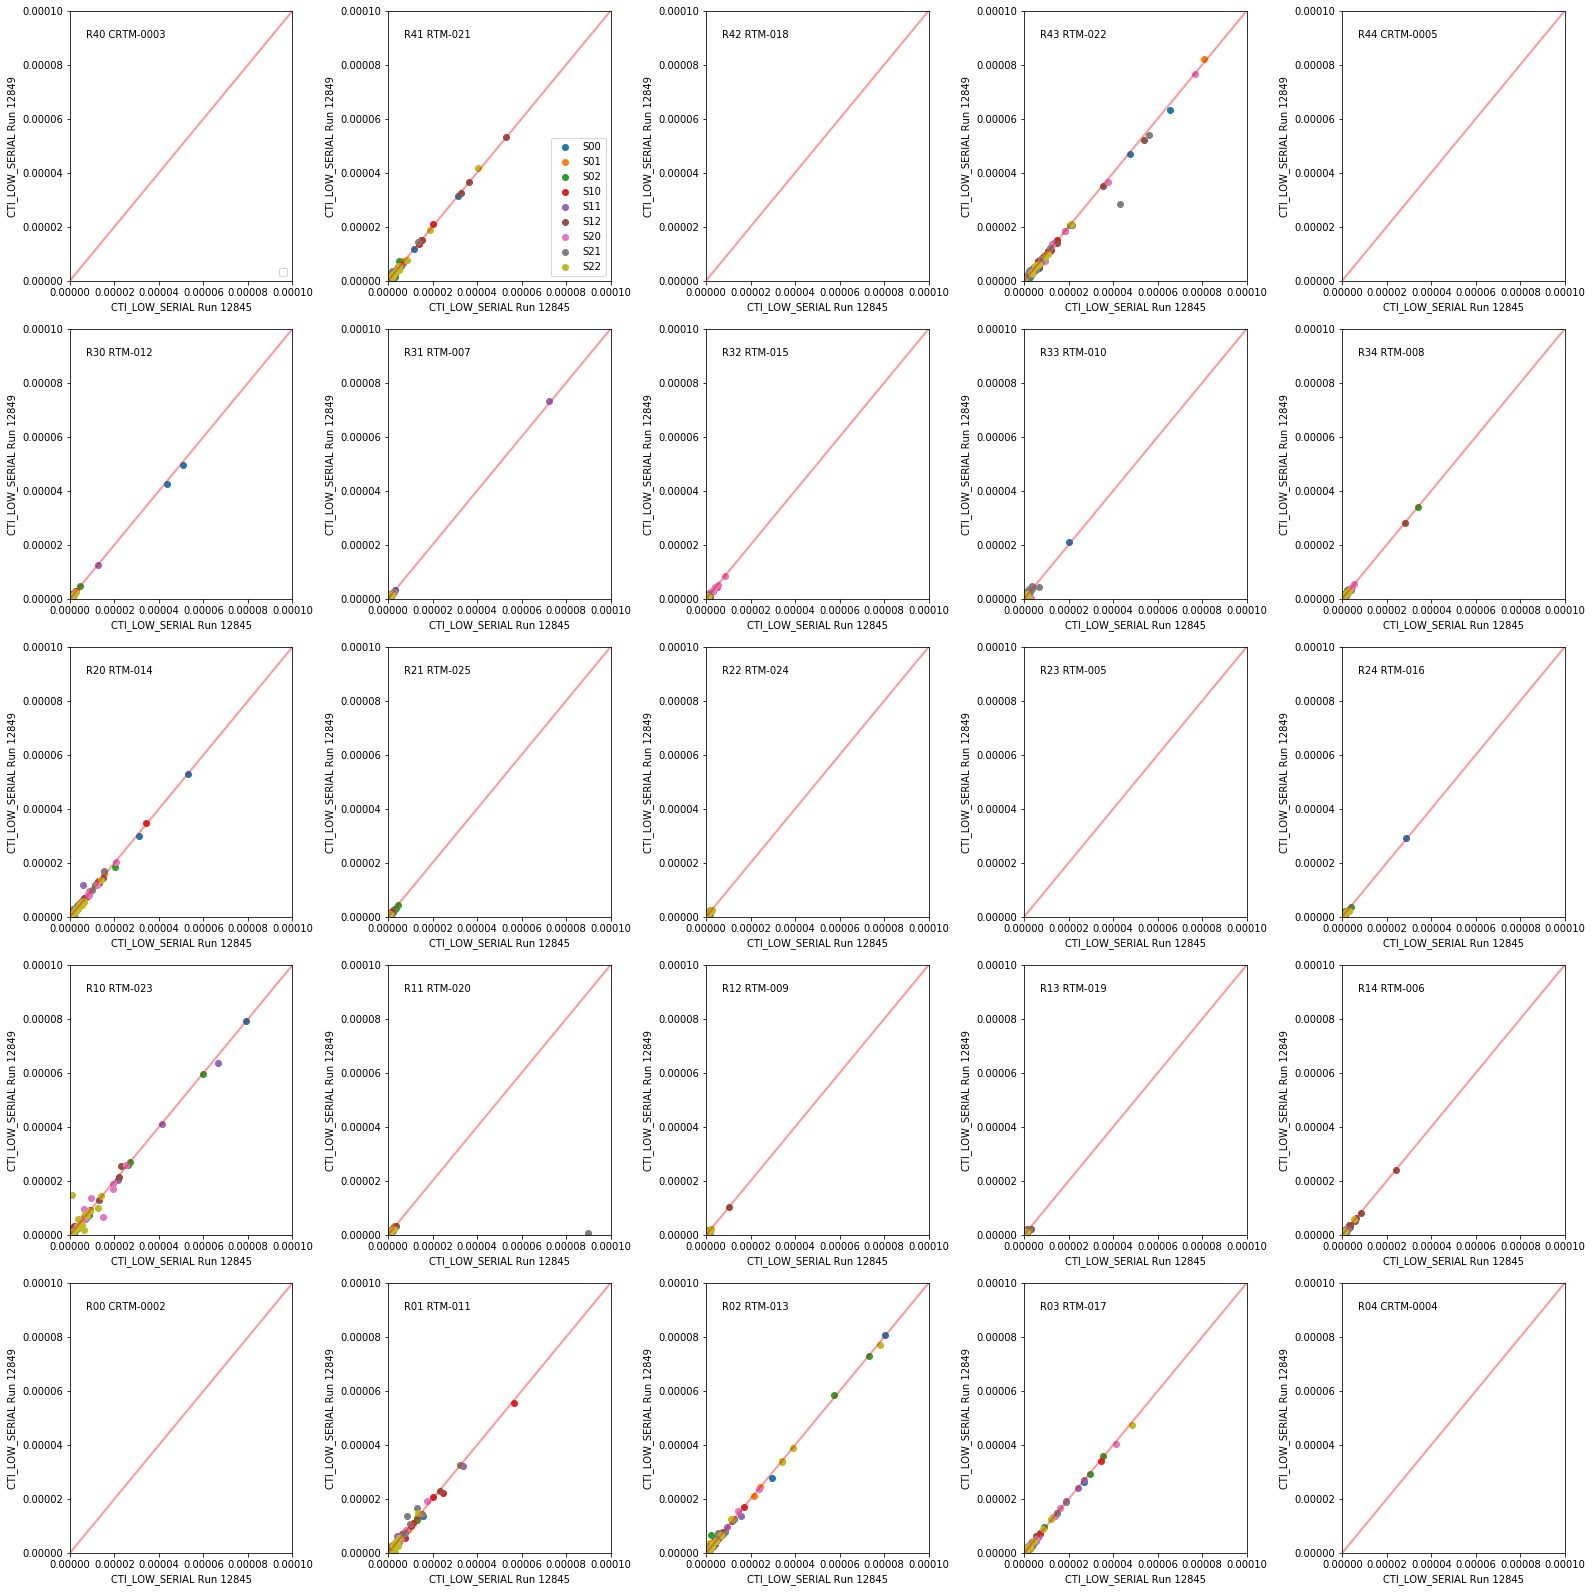

In [15]:
compare_tworuns(df_12845,df_12849,'12845','12849',quantity='CTI_LOW_SERIAL',minxy=0.,maxxy=1.e-4)

No handles with labels found to put in legend.


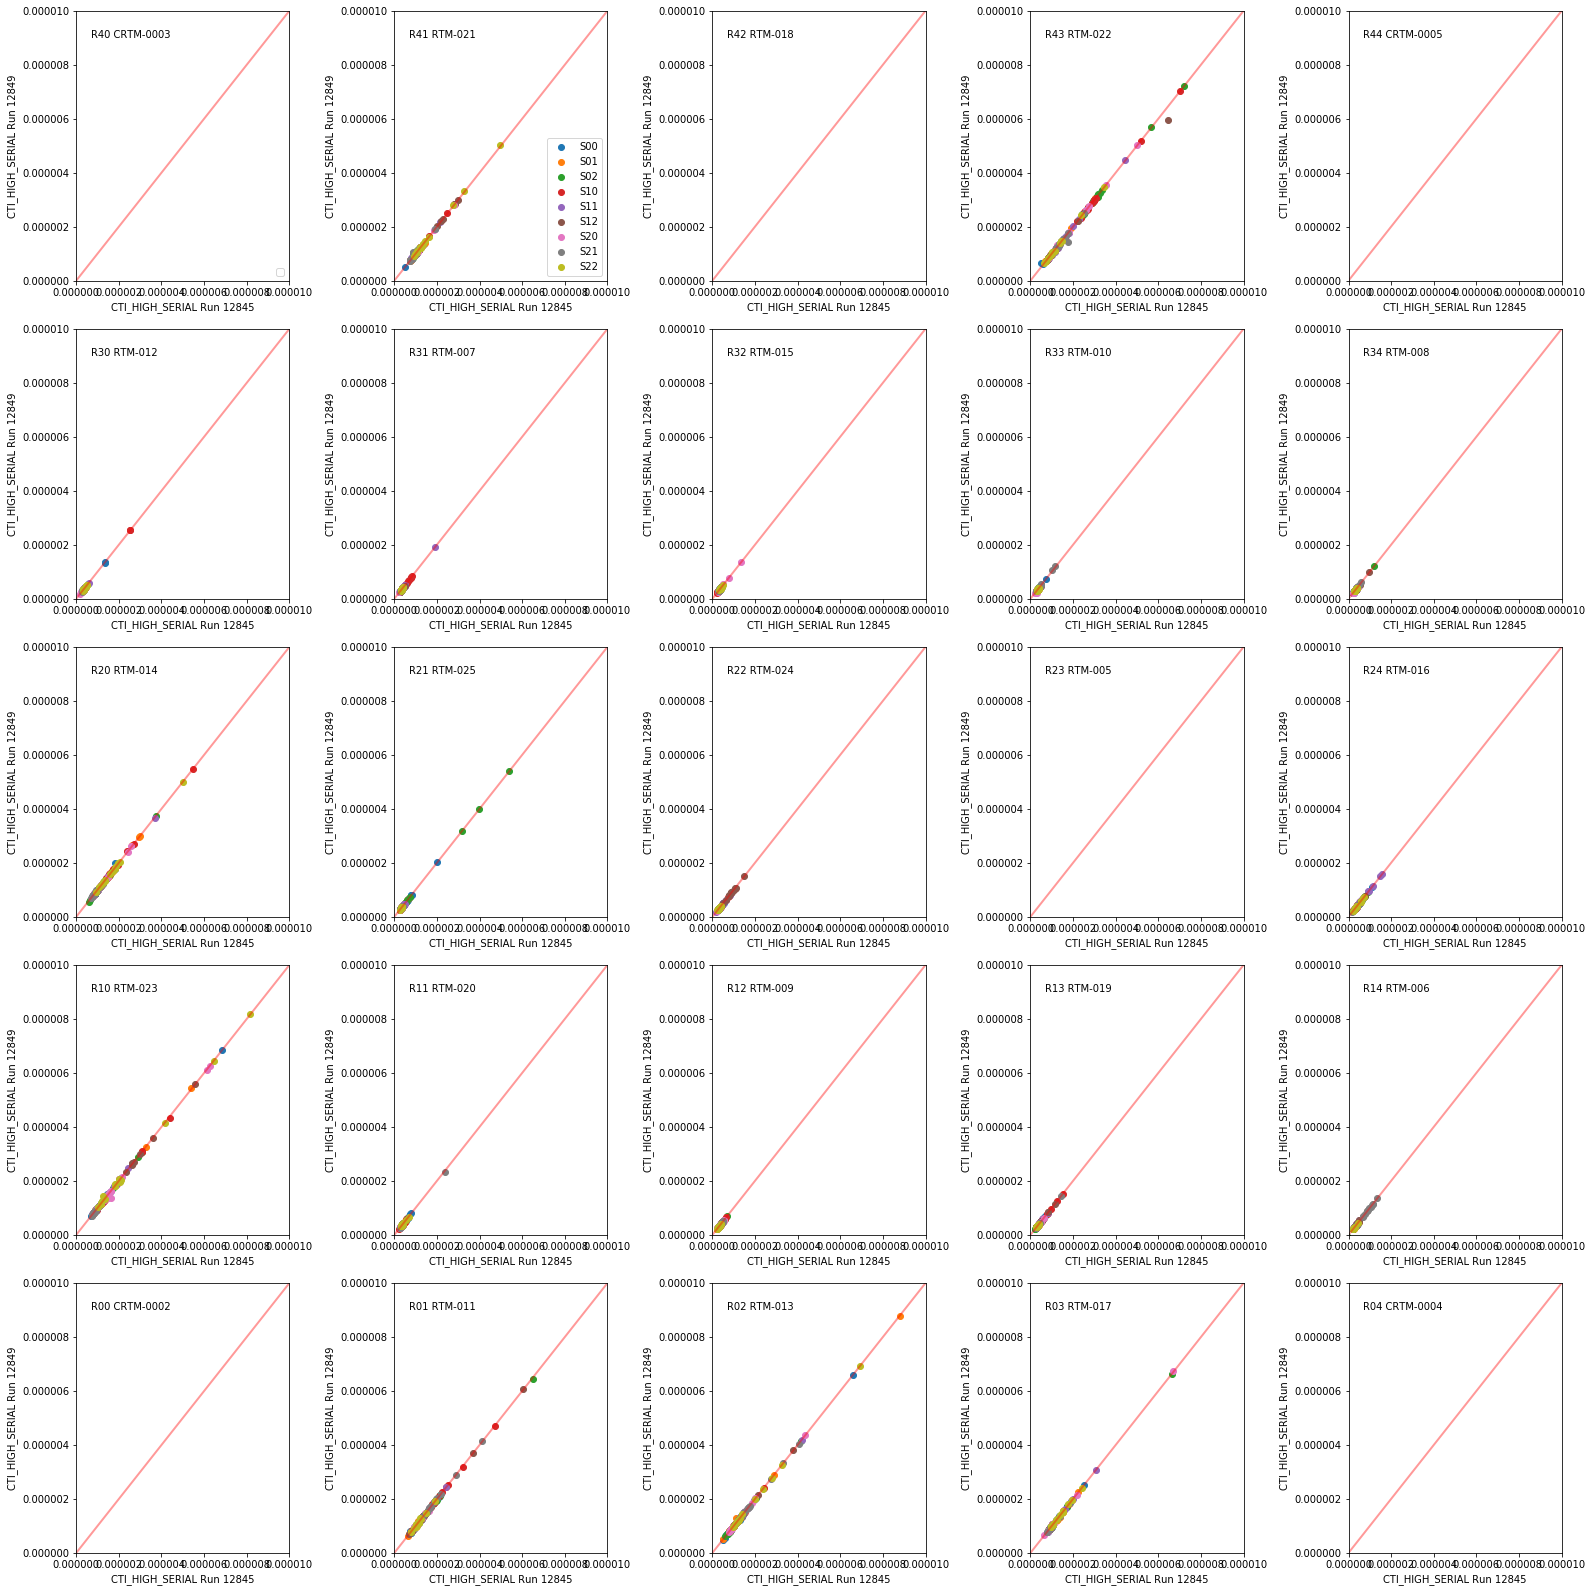

In [16]:
compare_tworuns(df_12845,df_12849,'12845','12849',quantity='CTI_HIGH_SERIAL',minxy=0.,maxxy=1.e-5)

No handles with labels found to put in legend.


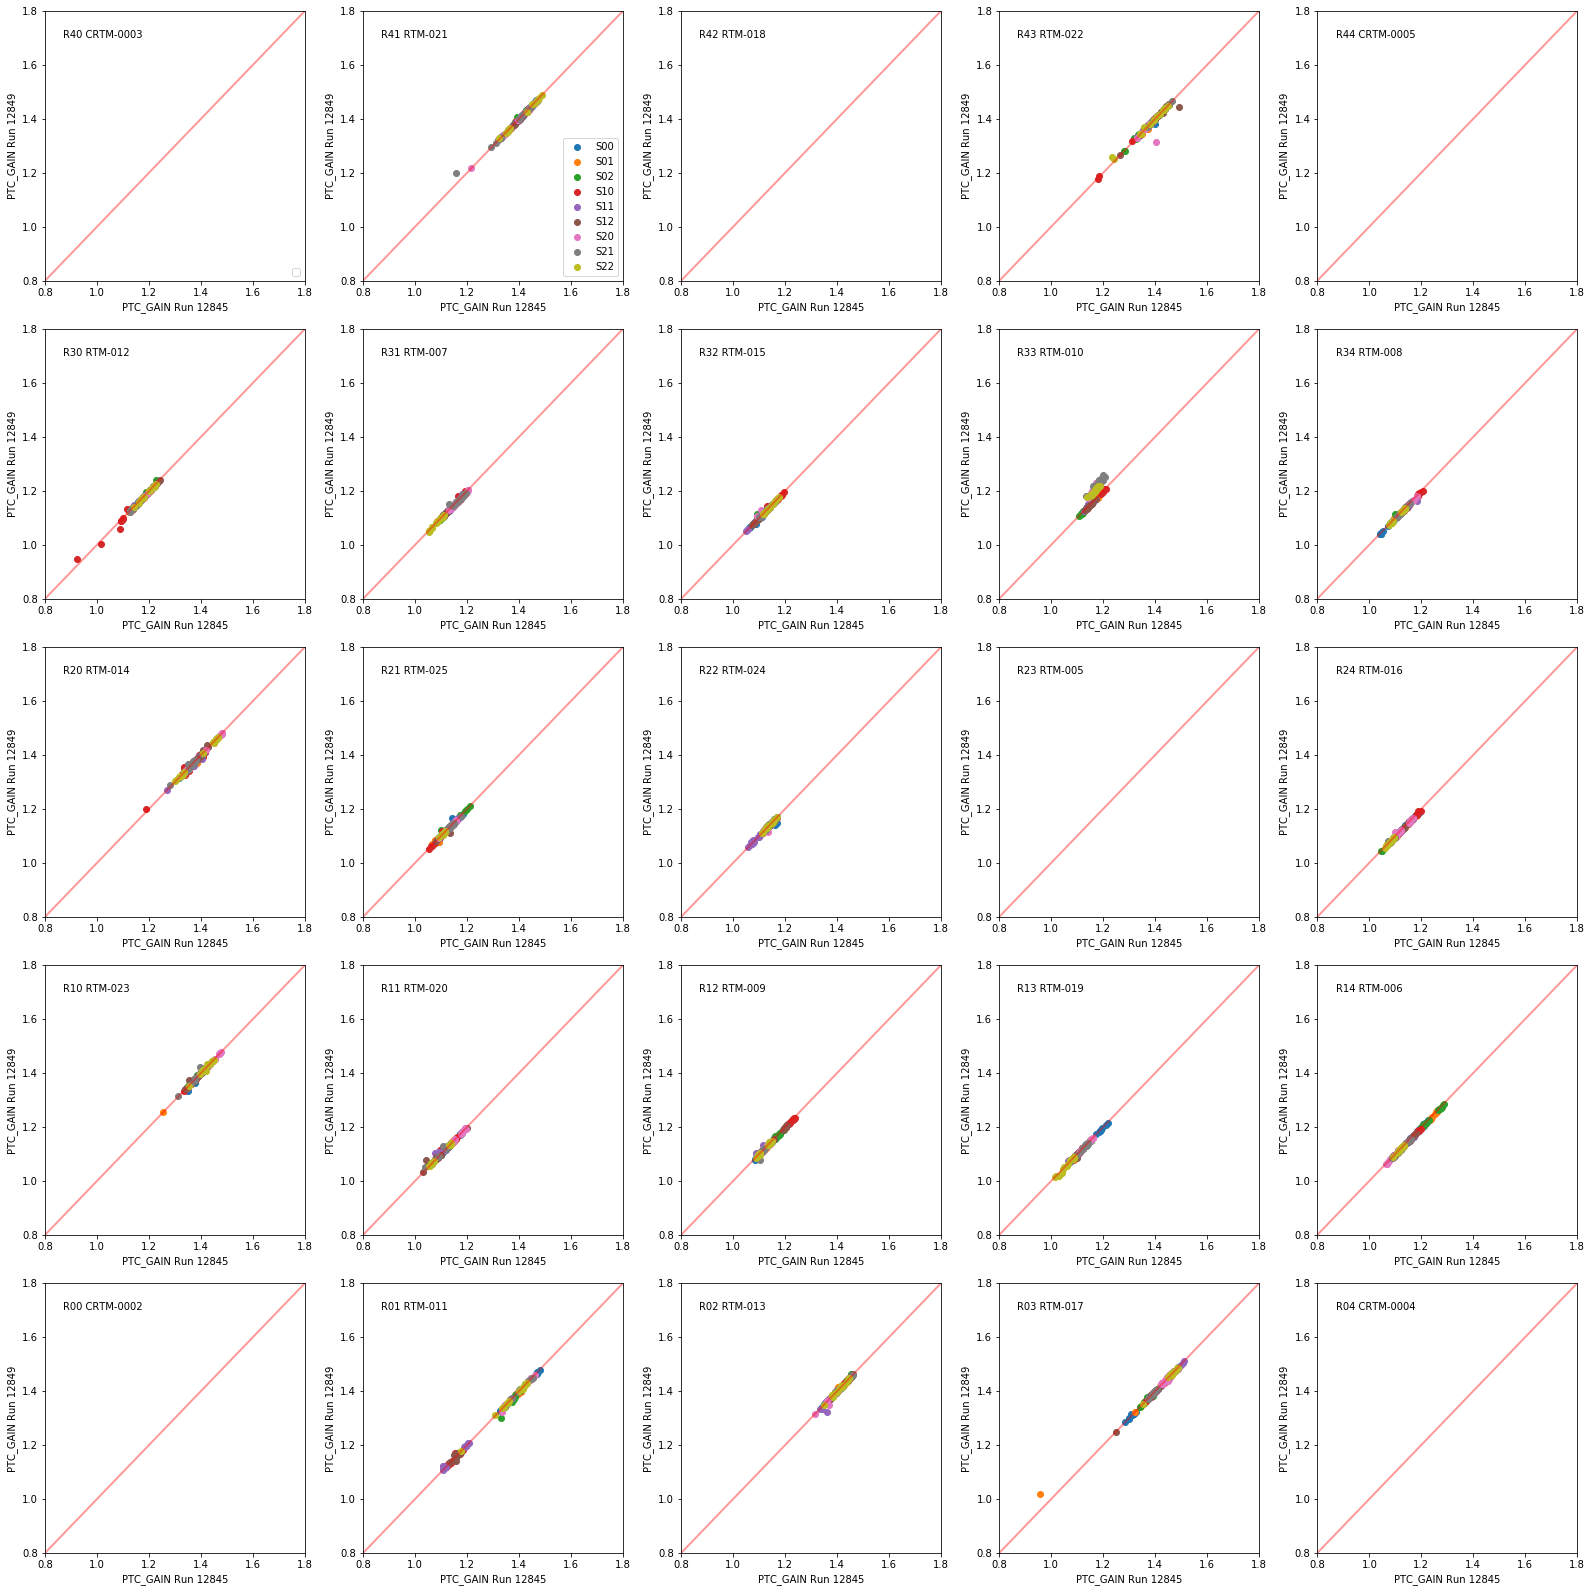

In [17]:
compare_tworuns(df_12845,df_12849,'12845','12849',quantity='PTC_GAIN',minxy=0.8,maxxy=1.8)

No handles with labels found to put in legend.


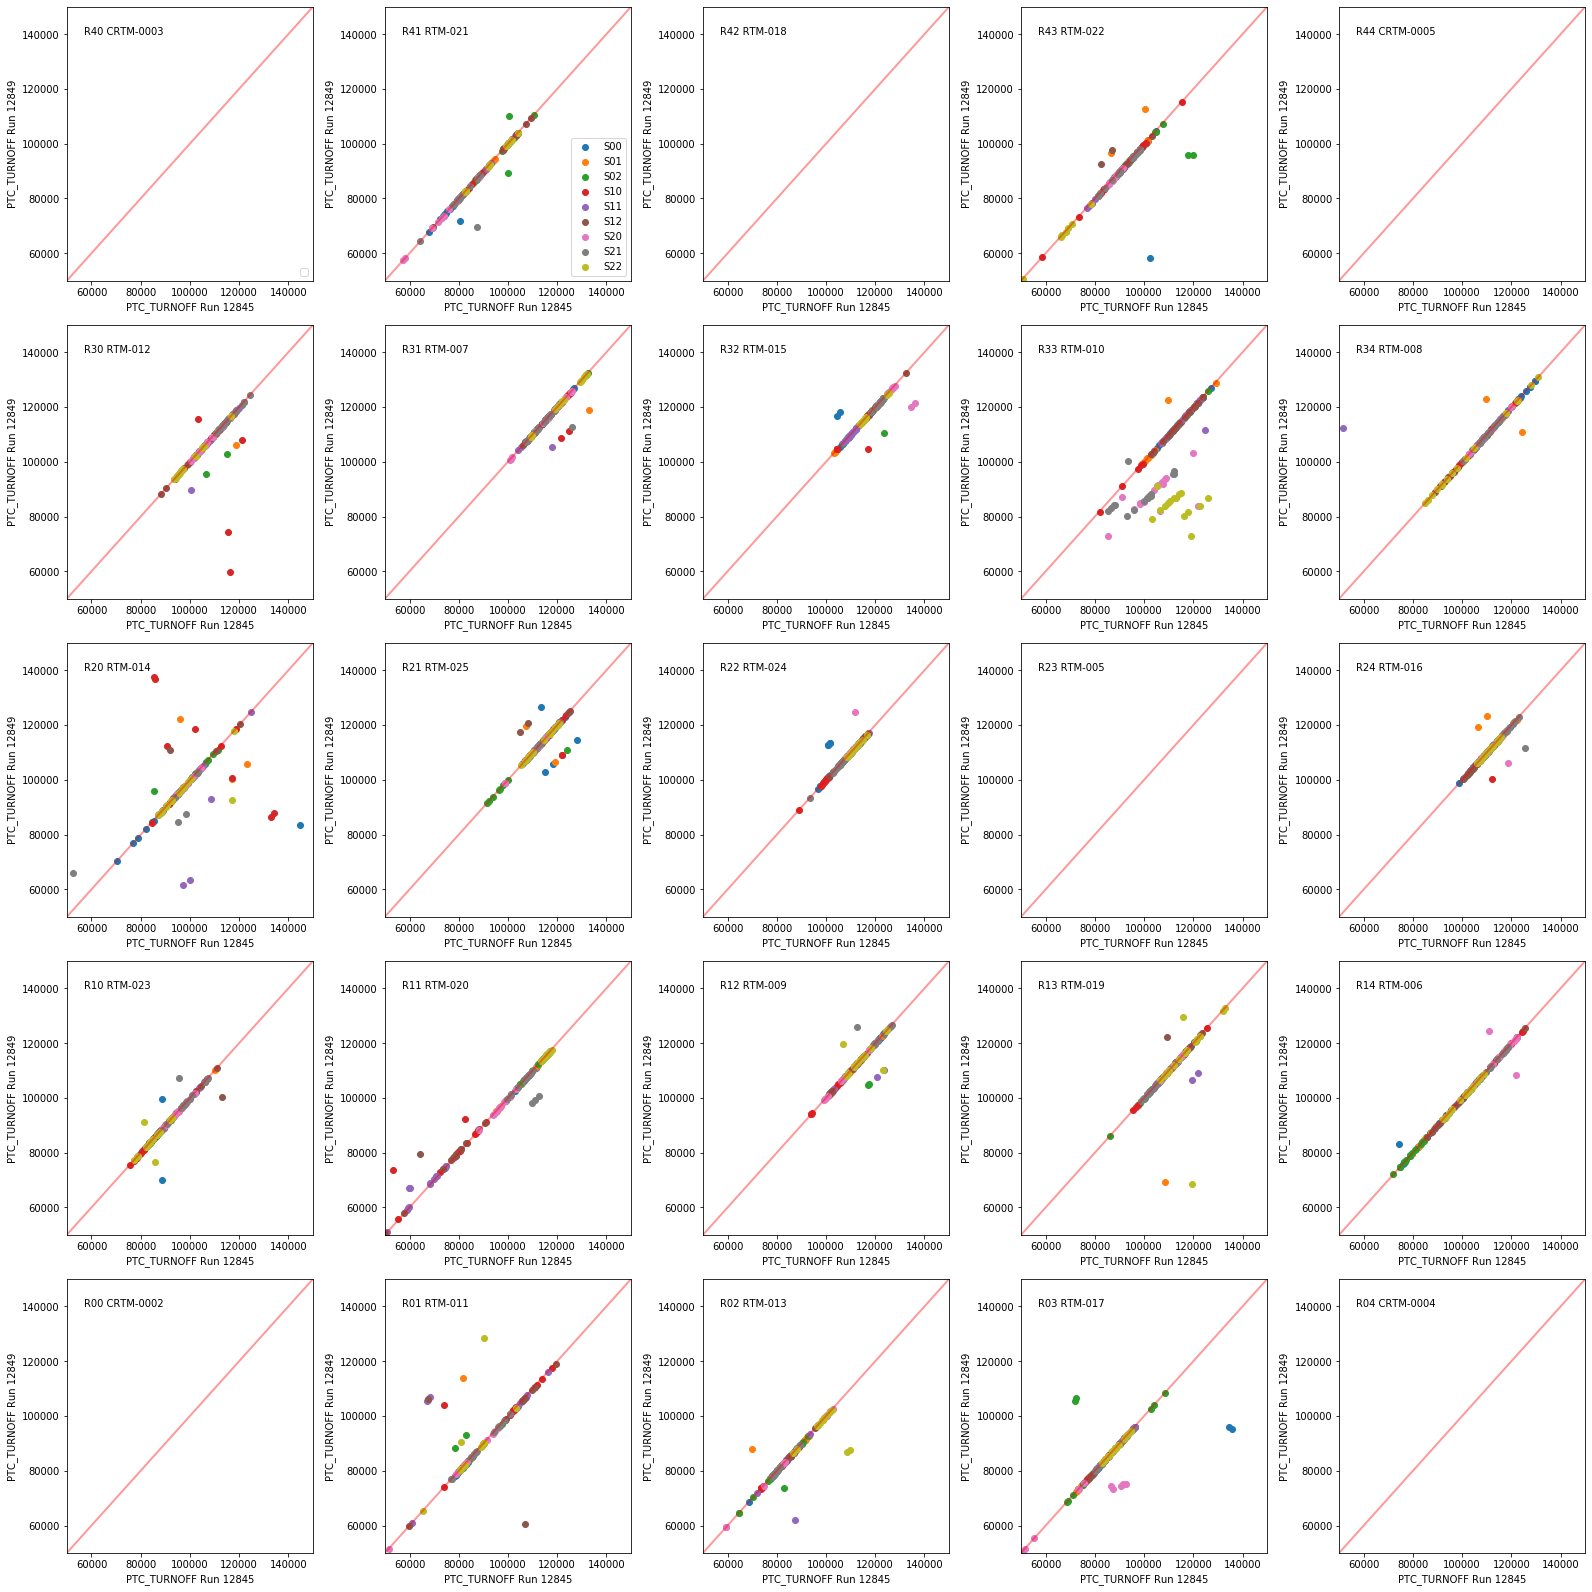

In [18]:
compare_tworuns(df_12845,df_12849,'12845','12849',quantity='PTC_TURNOFF',minxy=5.0e4,maxxy=15.0e4)

# compare with Run 12851

No handles with labels found to put in legend.


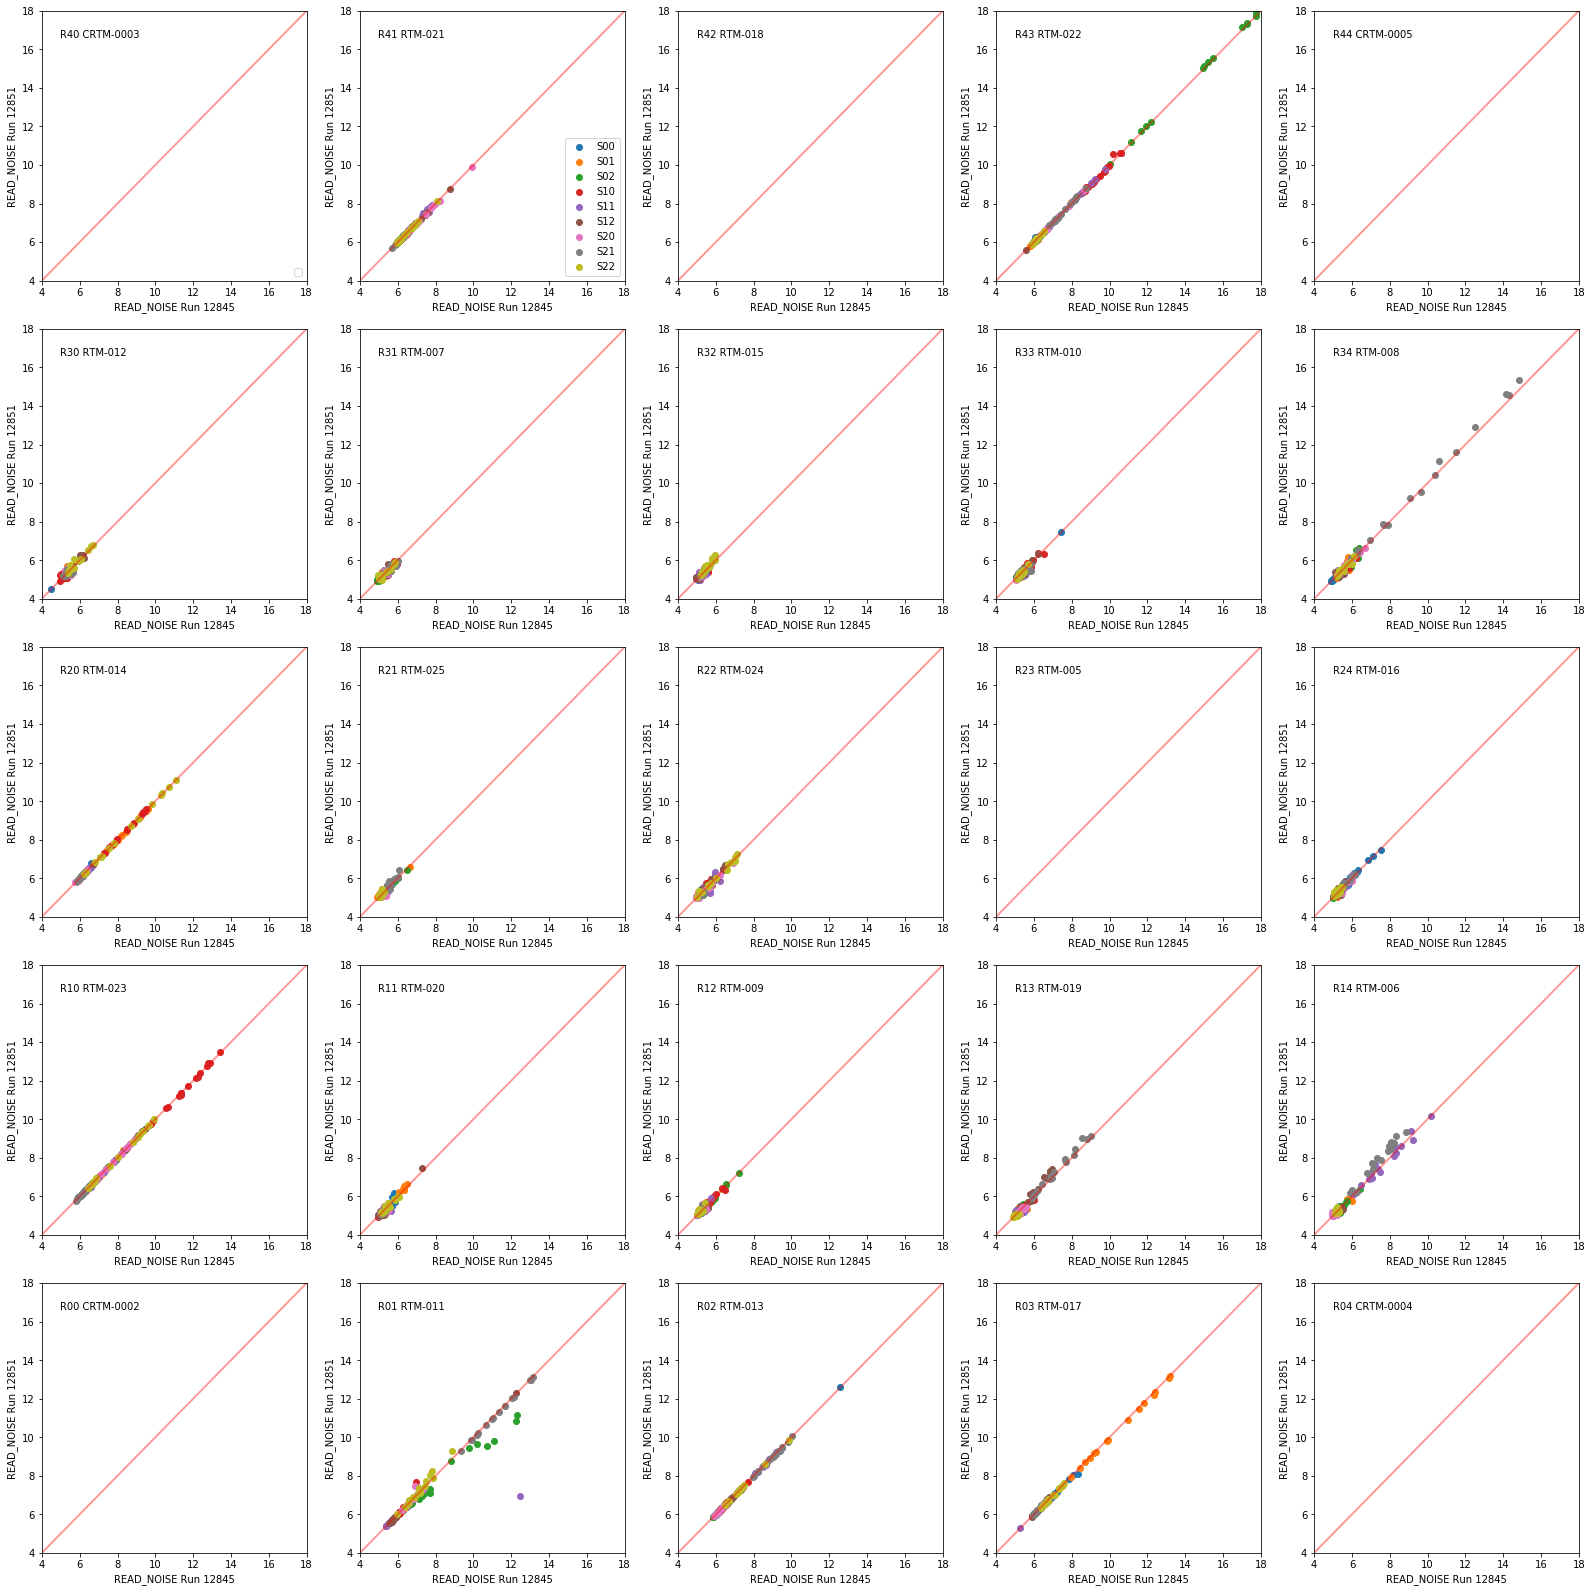

In [19]:
compare_tworuns(df_12845,df_12851,'12845','12851',minxy=4.,maxxy=18.)